In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import random

In [53]:
df = pd.read_csv('/content/KDDTrain+.txt')

In [54]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','level'])

In [55]:
df.columns = columns

In [56]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


### Data preprocessing

In [57]:
# Drop unnecessary columns
df = df.drop(['num_outbound_cmds'], axis=1)
# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
# Convert labels to binary: normal (0) or attack (1)
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Split data into features and labels
X = df.drop(['label'], axis=1)
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Perform feature selection using Harmony Search algorithm

In [58]:
def evaluate_features(X, y, n_features):
    selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_new = selector.fit_transform(X, y)
    return X_new, selector.scores_

In [61]:
def harmony_search(X, y, n_features, max_iter, hms=10, hmcr=0.95, par=0.5):
    # Initialize the harmony memory
    harmony_memory = np.zeros((hms, X.shape[1]), dtype=int)
    for i in range(hms):
        # Randomly initialize the harmony
        harmony = np.zeros(X.shape[1], dtype=int)
        for j in range(X.shape[1]):
            if random.random() < hmcr:
                # Use memory consideration to determine the value of the harmony
                if random.random() < par:
                    harmony[j] = 1
                else:
                    harmony[j] = 0
            else:
                # Randomly select a value for the harmony
                harmony[j] = random.randint(0, 1)
        harmony_memory[i] = harmony

    # Evaluate the fitness of the initial harmony memory
    X_hm, scores_hm = evaluate_features(X_train, y_train, n_features)
    best_harmony = np.argmin(scores_hm)
    best_score = scores_hm[best_harmony]

    # Harmony Search main loop
    for t in range(max_iter):
        print(f"Iteration {t}")
        # Generate a new harmony
        harmony = np.zeros(X.shape[1], dtype=int)
        for j in range(X.shape[1]):
            if random.random() < hmcr:
                if random.random() < par:
                    harmony[j] = 1
                else:
                    harmony[j] = 0
            else:
                harmony[j] = random.randint(0, 1)

        # Evaluate the fitness of the new harmony
        X_h, scores_h = evaluate_features(X_train, y_train, n_features)
        worst_harmony = np.argmax(scores_h)
        worst_score = scores_h[worst_harmony]

        # Update the harmony memory
        if scores_h[worst_harmony] < best_score and worst_harmony < hms:
            worst_harmony = worst_harmony % hms
            harmony_memory[worst_harmony, :n_features] = harmony
            best_harmony = worst_harmony
            best_score = scores_h[worst_harmony]

    # Create a boolean index with the same shape as X_train.columns
    boolean_index = np.zeros_like(X_train.columns, dtype=bool)
    boolean_index[:n_features][harmony_memory[best_harmony, :n_features] == 1] = True

    selected_features = X_train.columns[boolean_index]
    return selected_features

In [62]:
n_features = 25 # Number of features to select
max_iter = 5 # Maximum number of iterations
selected_features = harmony_search(X_train, y_train, n_features, max_iter)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [63]:
selected_features

Index(['duration', 'service', 'flag', 'src_bytes', 'dst_bytes',
       'wrong_fragment', 'urgent', 'num_failed_logins', 'logged_in',
       'root_shell', 'su_attempted', 'num_shells', 'is_host_login',
       'is_guest_login', 'count', 'serror_rate', 'srv_serror_rate'],
      dtype='object')

In [64]:
X[selected_features]

,duration,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,num_failed_logins,logged_in,root_shell,su_attempted,num_shells,is_host_login,is_guest_login,count,serror_rate,srv_serror_rate
0,0,44,9,146,0,0,0,0,0,0,0,0,0,0,13,0.0,0.0
1,0,49,5,0,0,0,0,0,0,0,0,0,0,0,123,1.0,1.0
2,0,24,9,232,8153,0,0,0,1,0,0,0,0,0,5,0.2,0.2
3,0,24,9,199,420,0,0,0,1,0,0,0,0,0,30,0.0,0.0
4,0,49,1,0,0,0,0,0,0,0,0,0,0,0,121,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,49,5,0,0,0,0,0,0,0,0,0,0,0,184,1.0,1.0
125968,8,49,9,105,145,0,0,0,0,0,0,0,0,0,2,0.0,0.0
125969,0,54,9,2231,384,0,0,0,1,0,0,0,0,0,1,0.0,0.0
125970,0,30,5,0,0,0,0,0,0,0,0,0,0,0,144,1.0,1.0


In [65]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [84]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [85]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [86]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                1152      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               66048     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 128)              

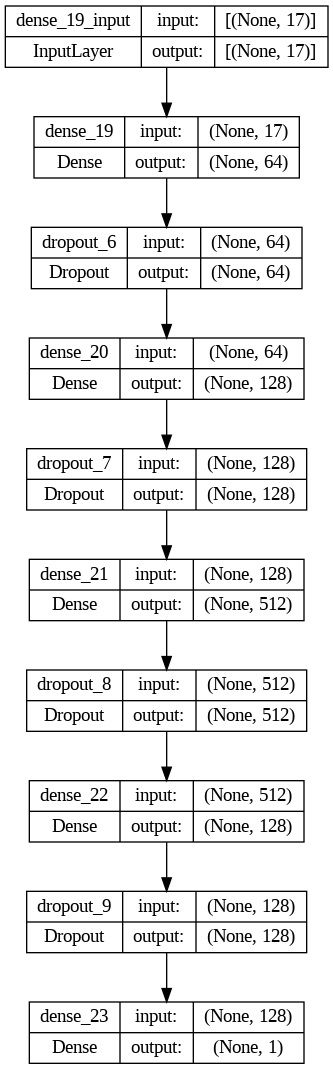

In [88]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [92]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2753/2756 [============================>.] - ETA: 0s - loss: 128317048.0000 - accuracy: 0.8755

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2756/2756 [==============================] - 21s 7ms/step - loss: 128194816.0000 - accuracy: 0.8755 - val_loss: 42087456.0000 - val_accuracy: 0.9340
Epoch 2/10
2756/2756 [==============================] - 19s 7ms/step - loss: 71477872.0000 - accuracy: 0.9341 - val_loss: 15045154.0000 - val_accuracy: 0.9487
Epoch 3/10
2756/2756 [==============================] - 19s 7ms/step - loss: 36847336.0000 - accuracy: 0.9419 - val_loss: 5096524.5000 - val_accuracy: 0.9538
Epoch 4/10
2756/2756 [==============================] - 20s 7ms/step - loss: 16600596.0000 - accuracy: 0.9465 - val_loss: 1246453.0000 - val_accuracy: 0.9593
Epoch 5/10
2756/2756 [==============================] - 22s 8ms/step - loss: 4523518.5000 - accuracy: 0.9504 - val_loss: 152869.4844 - val_accuracy: 0.9637
Epoch 6/10
2756/2756 [==============================] - 18s 7ms/step - loss: 710698.0625 - accuracy: 0.9534 - val_loss: 4791.4185 - val_accuracy: 0.9622
Epoch 7/10
2756/2756 [==============================] - 20s 7ms/ste

### ABC

In [93]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [98]:
# Define the Artificial Bee Colony (ABC) optimization algorithm
class ArtificialBeeColony(BaseEstimator, ClassifierMixin):
    def __init__(self, n_employees=20, n_scouts=5, max_iter=100, model=DecisionTreeClassifier()):
        self.n_employees = n_employees  # Number of employed bees
        self.n_scouts = n_scouts  # Number of scout bees
        self.max_iter = max_iter  # Maximum number of iterations
        self.model = model  # Model for fitness evaluation
        self.best_solution = None  # Best solution found
        self.best_fitness = None  # Best fitness value found

    def _random_solution(self):
        return np.random.choice([0, 1], size=self.n_features)

    def _fitness(self, solution, X, y):
        selected_features_indices = np.nonzero(solution)[0]
        X_selected = X.iloc[:, selected_features_indices]
        X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.best_solution = self._random_solution()
        self.best_fitness = self._fitness(self.best_solution, X, y)
        
        for t in range(self.max_iter):
            print(f"Iteration {t}")
            for i in range(self.n_employees):
                solution = self._random_solution()
                fitness = self._fitness(solution, X, y)
                if fitness > self.best_fitness:
                    self.best_solution = solution.copy()
                    self.best_fitness = fitness
            
            for i in range(self.n_scouts):
                candidate_solution = self._random_solution()
                candidate_fitness = self._fitness(candidate_solution, X, y)
                if candidate_fitness > self.best_fitness:
                    self.best_solution = candidate_solution.copy()
                    self.best_fitness = candidate_fitness
        
        return self.best_solution, self.best_fitness

In [102]:
n_employees = 20  # Number of employed bees
n_scouts = 5  # Number of scout bees
max_iter = 25  # Maximum number of iterations
model = DecisionTreeClassifier()
abc = ArtificialBeeColony(n_employees, n_scouts, max_iter, model)

In [103]:
best_solution, best_fitness = abc.fit(X_train, y_train)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24


In [104]:
selected_features_indices = np.nonzero(best_solution)[0]

In [105]:
X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

In [106]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [108]:
model_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [110]:
history_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2754/2756 [============================>.] - ETA: 0s - loss: 80761248.0000 - accuracy: 0.8678

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2756/2756 [==============================] - 24s 8ms/step - loss: 80713624.0000 - accuracy: 0.8679 - val_loss: 79698856.0000 - val_accuracy: 0.9440
Epoch 2/10
2756/2756 [==============================] - 20s 7ms/step - loss: 32967016.0000 - accuracy: 0.9333 - val_loss: 23097578.0000 - val_accuracy: 0.9584
Epoch 3/10
2756/2756 [==============================] - 21s 7ms/step - loss: 8801952.0000 - accuracy: 0.9457 - val_loss: 3323539.2500 - val_accuracy: 0.9407
Epoch 4/10
2756/2756 [==============================] - 23s 8ms/step - loss: 1244888.2500 - accuracy: 0.9462 - val_loss: 147252.8125 - val_accuracy: 0.9587
Epoch 5/10
2756/2756 [==============================] - 19s 7ms/step - loss: 29425.4844 - accuracy: 0.9527 - val_loss: 0.2469 - val_accuracy: 0.9620
Epoch 6/10
2756/2756 [==============================] - 21s 8ms/step - loss: 0.2662 - accuracy: 0.9526 - val_loss: 0.2487 - val_accuracy: 0.9541
Epoch 7/10
2756/2756 [==============================] - 20s 7ms/step - loss: 0.2519 - 